In [135]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [218]:

notes_df = pd.read_csv("Notes.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("Test.csv",encoding='latin1')


def get_note(row):
    note_row = notes_df[notes_df["ID"] == row["ID"]]
    return note_row[f"Segment{row['Segment']}_Notes"].values[0] if not note_row.empty else ""

train_df["Note"] = train_df.apply(get_note, axis=1)
test_df["Note"] = test_df.apply(get_note, axis=1)


train_df["text"] = train_df["Note"] + " [SEP] " + train_df["IdeaUnit"]
test_df["text"] = test_df["Note"] + " [SEP] " + test_df["IdeaUnit"]

class_0 = train_df[train_df["label"] == 0]
class_1 = train_df[train_df["label"] == 1]

class_0_under = class_0.sample(len(class_1), random_state=42)
undersampled_train_df = pd.concat([class_0_under, class_1]).sample(frac=1, random_state=42).reset_index(drop=True)


In [224]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)


train_dataset = Dataset.from_pandas(undersampled_train_df[["text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["text"]])

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Map:   0%|          | 0/9945 [00:00<?, ? examples/s]

In [248]:
model = BertForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased")

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",
    per_device_train_batch_size=16,
    num_train_epochs=5,
    logging_steps=10,
    save_strategy="no",
    learning_rate=3e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sahil\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [250]:
trainer.train()

Step,Training Loss
10,0.648800
20,0.620500
30,0.554800
40,0.488900
50,0.433200
60,0.328600
70,0.269100
80,0.272200


TrainOutput(global_step=80, training_loss=0.45200797021389005, metrics={'train_runtime': 3571.4442, 'train_samples_per_second': 0.347, 'train_steps_per_second': 0.022, 'total_flos': 326257708646400.0, 'train_loss': 0.45200797021389005, 'epoch': 5.0})

In [252]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=1)
test_df["predicted_label"] = preds
test_df[["ID", "Segment", "predicted_label"]].head()

,ID,Segment,predicted_label
0,6260230,1,1
1,6260230,1,1
2,6260230,1,0
3,6260230,1,0
4,6260230,1,0


In [254]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

eval_df = test_df.dropna(subset=["label", "predicted_label"])

y_true = eval_df["label"].astype(int)
y_pred = eval_df["predicted_label"].astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7531
Precision: 0.6708
Recall: 0.6218
F1 Score: 0.6454


In [256]:
print("Predicted label counts:")
print(test_df["predicted_label"].value_counts())

print("\nActual label counts:")
print(test_df["label"].value_counts())

Predicted label counts:
predicted_label
0    6614
1    3331
Name: count, dtype: int64

Actual label counts:
label
0.0    6350
1.0    3591
Name: count, dtype: int64


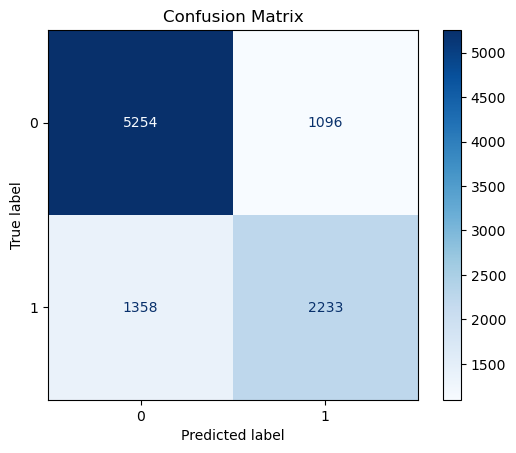

In [260]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()